In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa 
import pandas as pd 
from tqdm import tqdm
from IPython.display import Audio
from IPython.display import clear_output
from scipy import signal
import keras
from keras.models import Model
from keras.callbacks import EarlyStopping,ModelCheckpoint
import math
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20,10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
base_dir = '/kaggle/input/audio-mnist/data'
file_paths = []
for i in tqdm(os.listdir(base_dir)[:60]):
    try:
        for audio in os.listdir(os.path.join(base_dir,i)):
            file_paths.append(os.path.join(base_dir,i,audio))
    except Exception as e:
        pass

100%|██████████| 60/60 [00:06<00:00,  9.06it/s] 


In [ ]:
print(file_paths[0:100])

sample_rate 22050


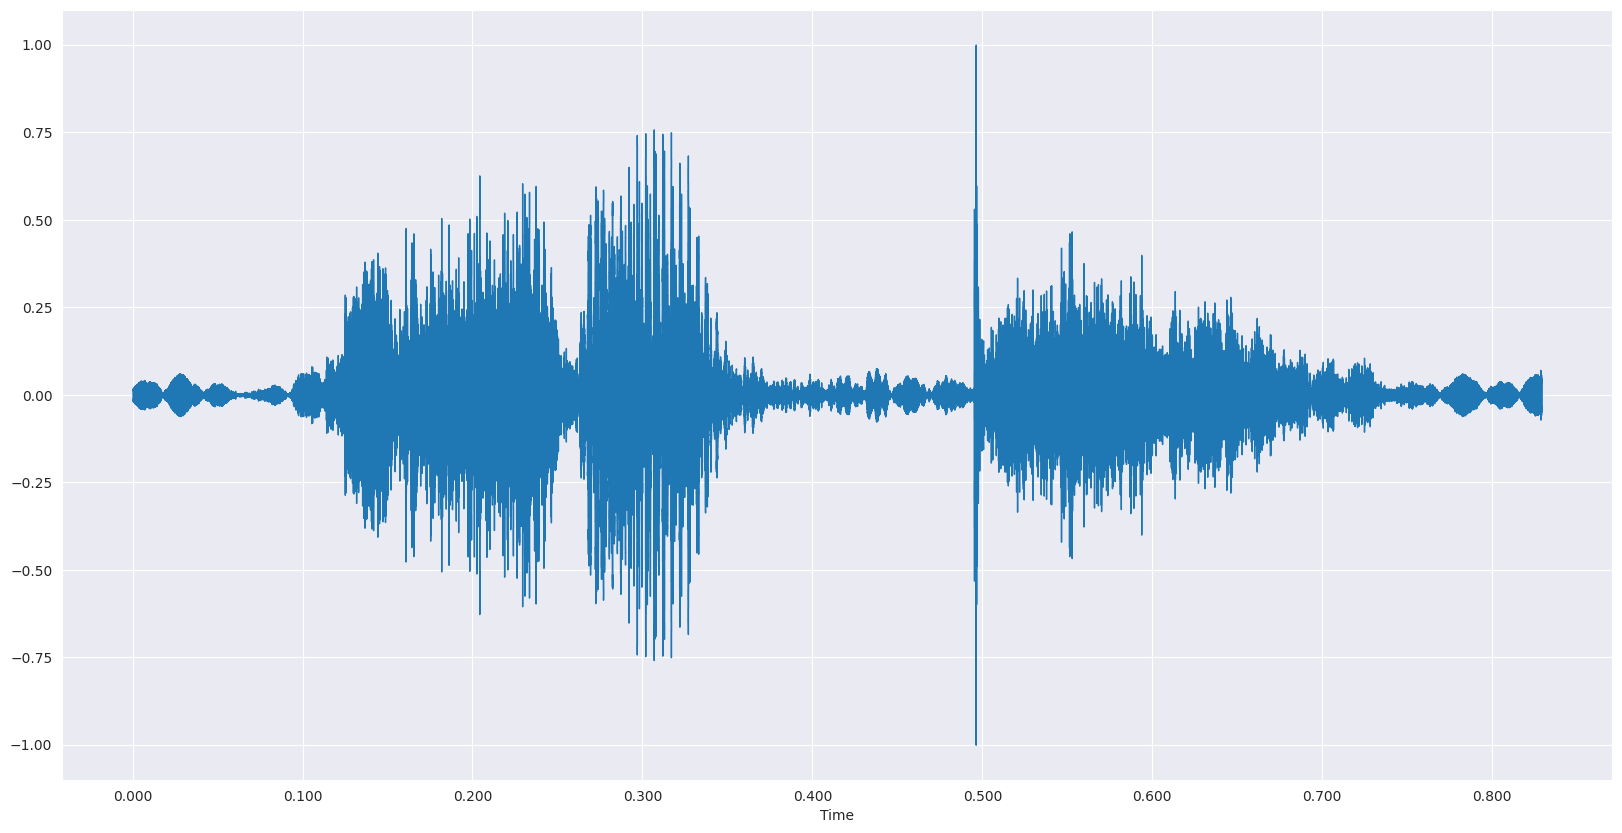

In [7]:
audio,sr = librosa.load(file_paths[0])
audio = librosa.util.normalize(audio)
audiowgt = Audio(data=audio,rate=sr)
display(audiowgt)
print('sample_rate',sr)
librosa.display.waveshow(audio,sr=sr)


In [4]:
all_wave = []
all_label = []


for file in tqdm(file_paths):
    clss = file.split('/')[-1].split('.')[0].split('_')[0]
    samples, sample_rate = librosa.load(file,sr=16000)
    #samples = librosa.resample(samples, orig_sr=sample_rate, target_sr=8000)
    samples=signal.resample(samples,8000)
    if(len(samples)== 8000) :
        samples = librosa.util.normalize(samples)
        all_wave.append(samples)
        all_label.append(int(clss))
        

100%|██████████| 29500/29500 [05:55<00:00, 83.09it/s]


<AxesSubplot: ylabel='Count'>

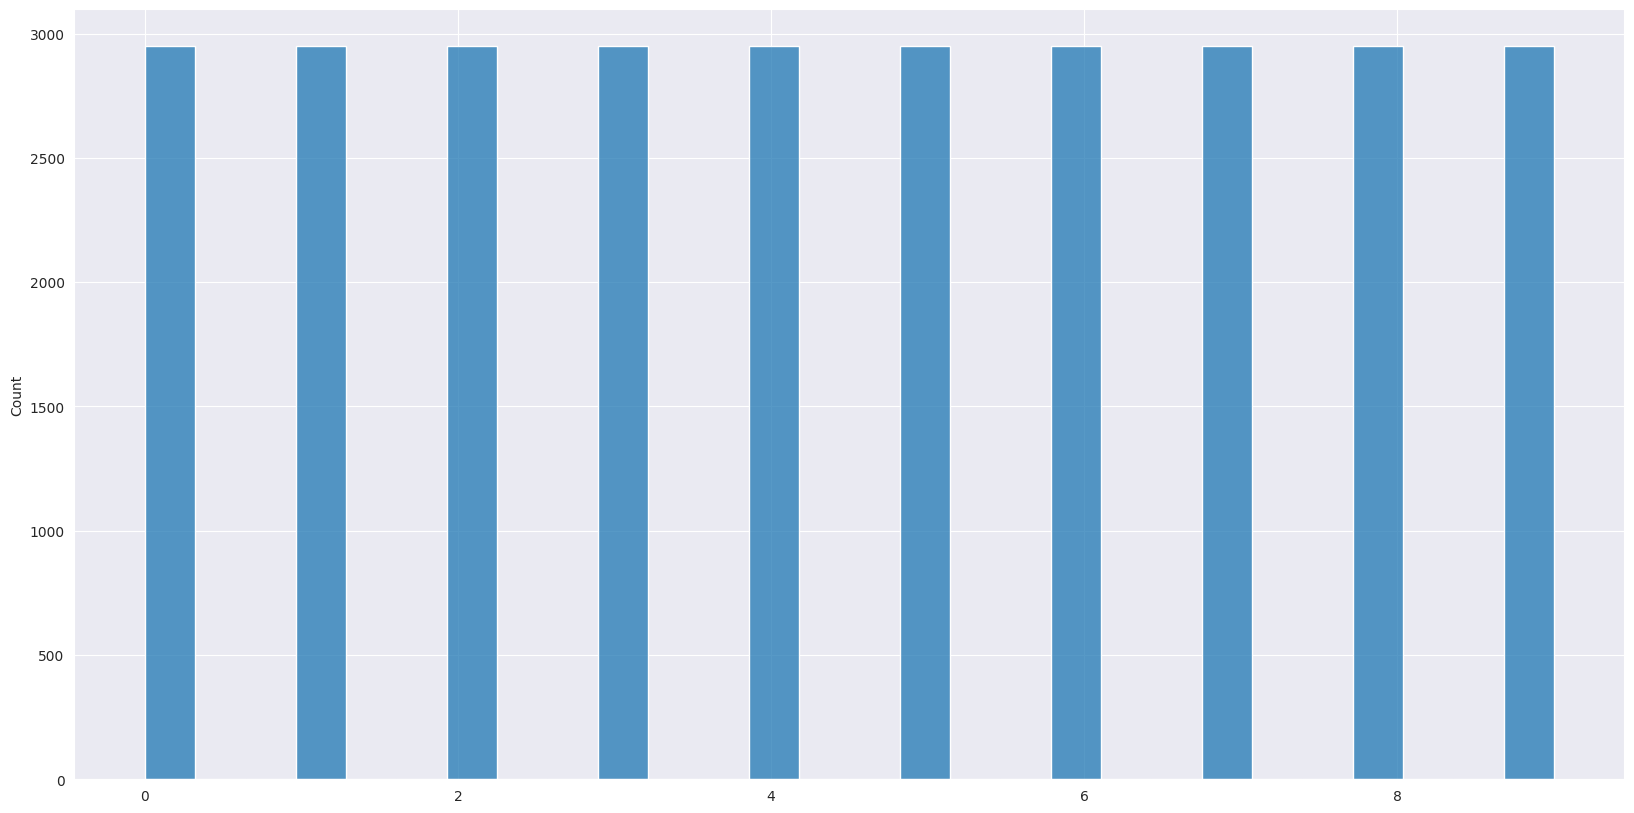

In [5]:

lab= pd.Series(all_label)
lab.value_counts()
sns.histplot(lab)


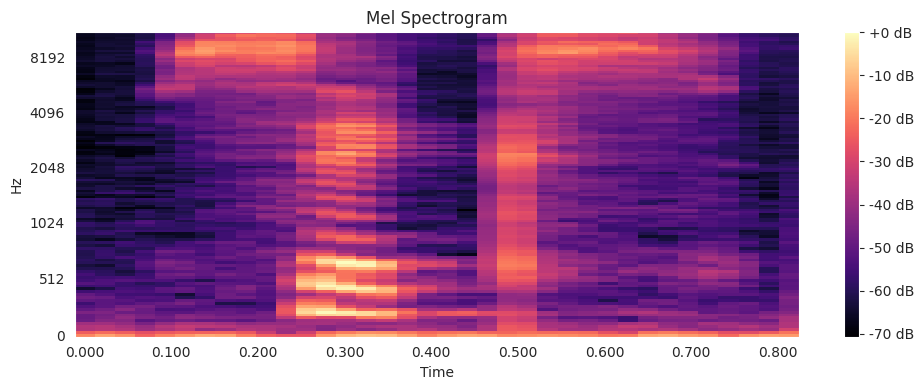

In [8]:
spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=8000)
spec_db = librosa.power_to_db(spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spec_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

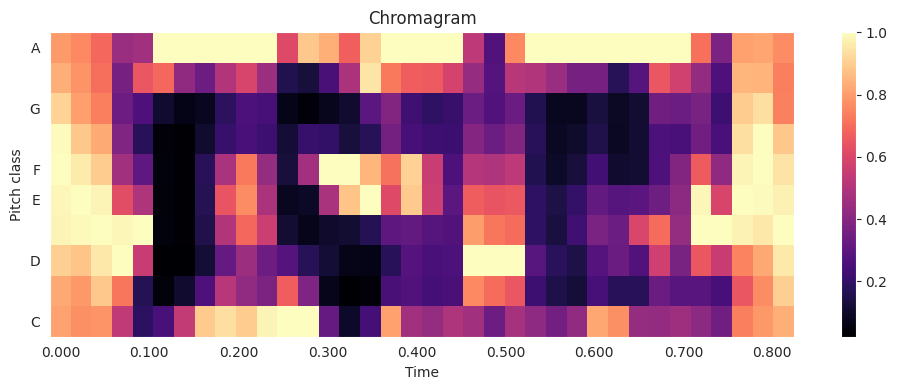

In [9]:
chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_chroma=10, hop_length=512)

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split
all_wave =np.array(all_wave).reshape(-1,8000,1)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:

X_train ,X_test,y_train,y_test =train_test_split(np.array(all_wave),np.array(all_label),test_size = 0.3,random_state=122,shuffle=True)

In [13]:
KerasModel = keras.models.Sequential([
        keras.layers.Conv1D(8,13,activation='relu',input_shape=(8000, 1)),
        keras.layers.MaxPooling1D(3),
        keras.layers.Dropout(0.2),
        keras.layers.Conv1D(16, 11,activation='relu'),
        keras.layers.MaxPooling1D(3),
        keras.layers.Dropout(0.2),
        keras.layers.Flatten() ,    
        keras.layers.Dense(128,activation='relu') ,
        keras.layers.Dense(64,activation='relu') ,  
        keras.layers.Dropout(rate=0.2) ,            
        keras.layers.Dense(10,activation='softmax') ,    
        ])

In [14]:
KerasModel.compile(optimizer ='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [15]:
print('Model Details are : ')
print(KerasModel.summary())

Model Details are : 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None,

In [16]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [17]:
history=KerasModel.fit(X_train, y_train ,epochs=10, callbacks=[es,mc], batch_size=32)

Epoch 1/10
646/646 [==============================] - 74s 112ms/step - loss: 0.6827 - accuracy: 0.7714
Epoch 2/10
646/646 [==============================] - 72s 111ms/step - loss: 0.2131 - accuracy: 0.9341
Epoch 3/10
646/646 [==============================] - 72s 112ms/step - loss: 0.1212 - accuracy: 0.9603
Epoch 4/10
646/646 [==============================] - 71s 110ms/step - loss: 0.0794 - accuracy: 0.9749
Epoch 5/10
646/646 [==============================] - 70s 108ms/step - loss: 0.0609 - accuracy: 0.9801
Epoch 6/10
646/646 [==============================] - 71s 110ms/step - loss: 0.0447 - accuracy: 0.9857
Epoch 7/10
646/646 [==============================] - 70s 109ms/step - loss: 0.0353 - accuracy: 0.9890
Epoch 8/10
646/646 [==============================] - 71s 109ms/step - loss: 0.0295 - accuracy: 0.9901
Epoch 9/10
646/646 [==============================] - 70s 109ms/step - loss: 0.0309 - accuracy: 0.9902
Epoch 10/10
646/646 [==============================] - 70s 108ms/step - l

In [18]:
ModelLoss, ModelAccuracy = KerasModel.evaluate(X_test, y_test)

print('Test Loss is {}'.format(ModelLoss))
print('Test Accuracy is {}'.format(ModelAccuracy ))

277/277 [==============================] - 8s 27ms/step - loss: 0.1429 - accuracy: 0.9679
Test Loss is 0.14288713037967682
Test Accuracy is 0.9679096341133118


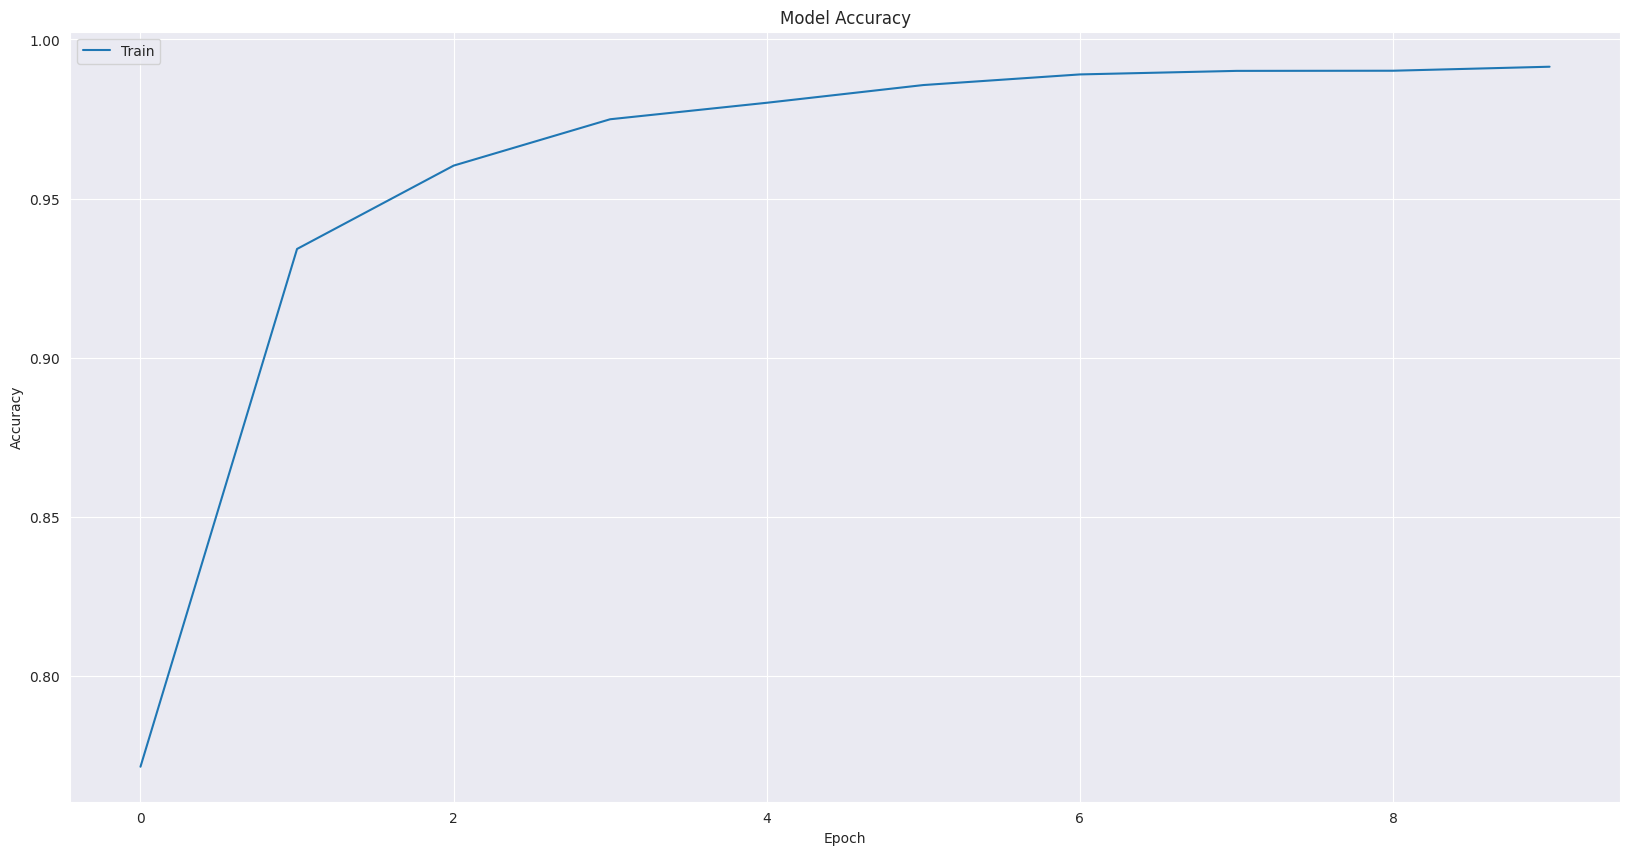

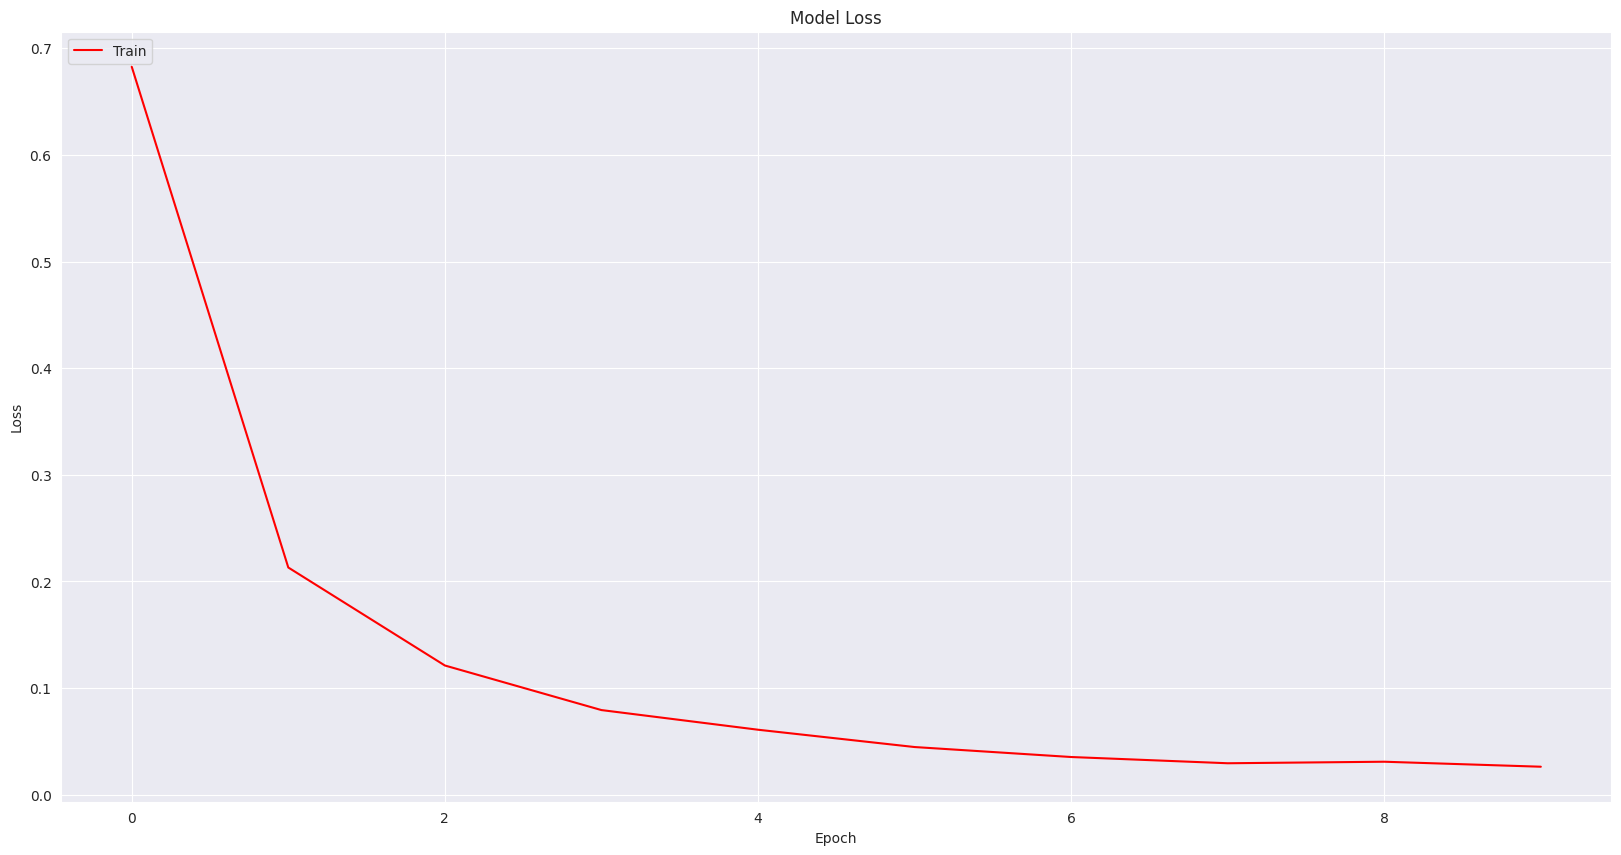

In [22]:


plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'],color='red')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
y_test
y_pred = KerasModel.predict(X_test)

277/277 [==============================] - 8s 28ms/step


In [24]:
preds = [np.argmax(i) for i in y_pred]


In [25]:
from sklearn.metrics import classification_report, confusion_matrix 
print(classification_report(y_test,preds))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97       904
           1       0.95      0.99      0.97       896
           2       0.98      0.97      0.98       865
           3       0.93      0.98      0.95       936
           4       0.96      0.98      0.97       894
           5       0.96      0.94      0.95       887
           6       0.99      0.99      0.99       867
           7       0.99      0.96      0.97       849
           8       0.99      0.95      0.97       894
           9       0.97      0.95      0.96       858

    accuracy                           0.97      8850
   macro avg       0.97      0.97      0.97      8850
weighted avg       0.97      0.97      0.97      8850



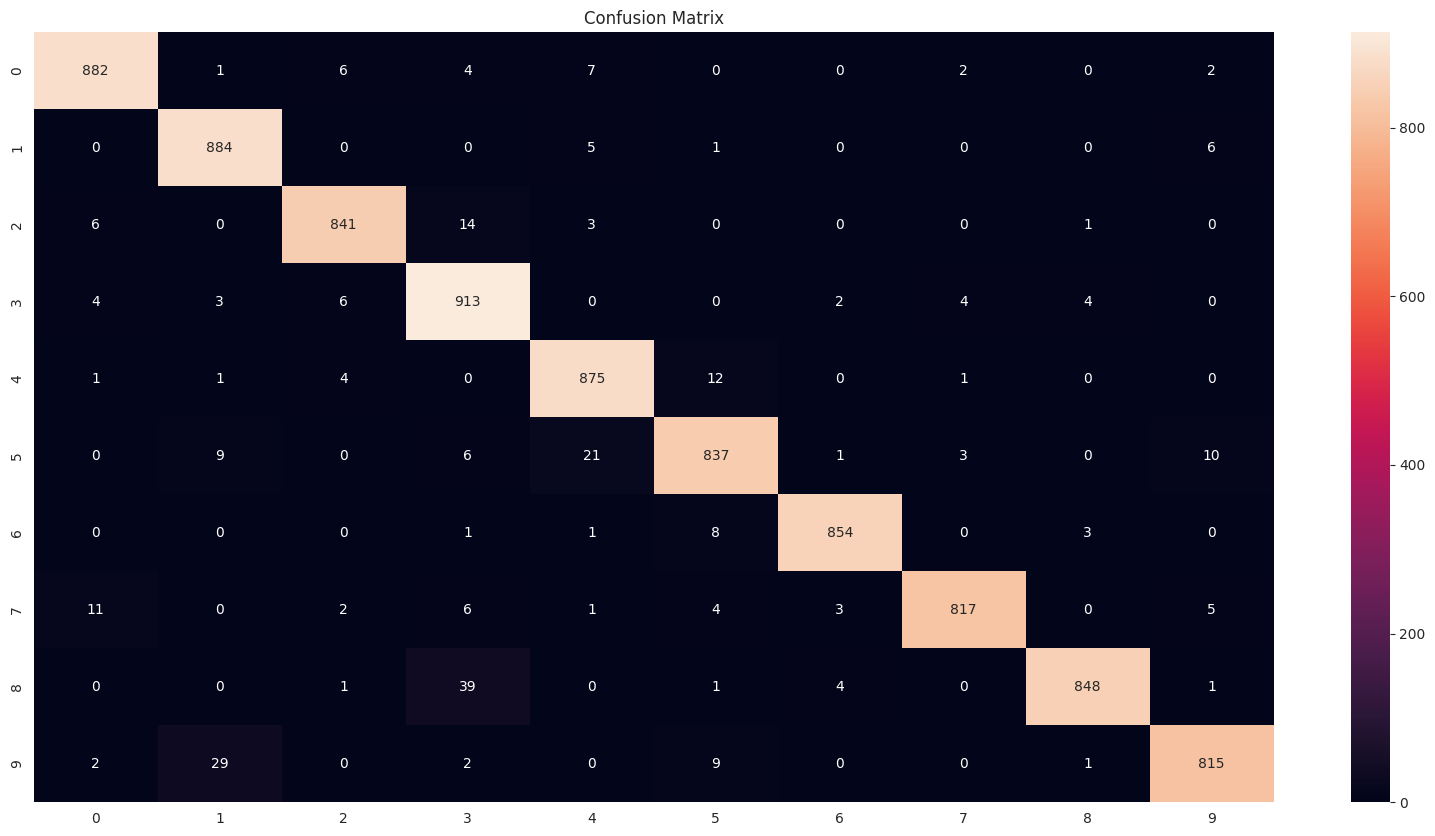

In [30]:
conf = confusion_matrix(y_test,preds)
sns.heatmap(conf,annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

<AxesSubplot: >

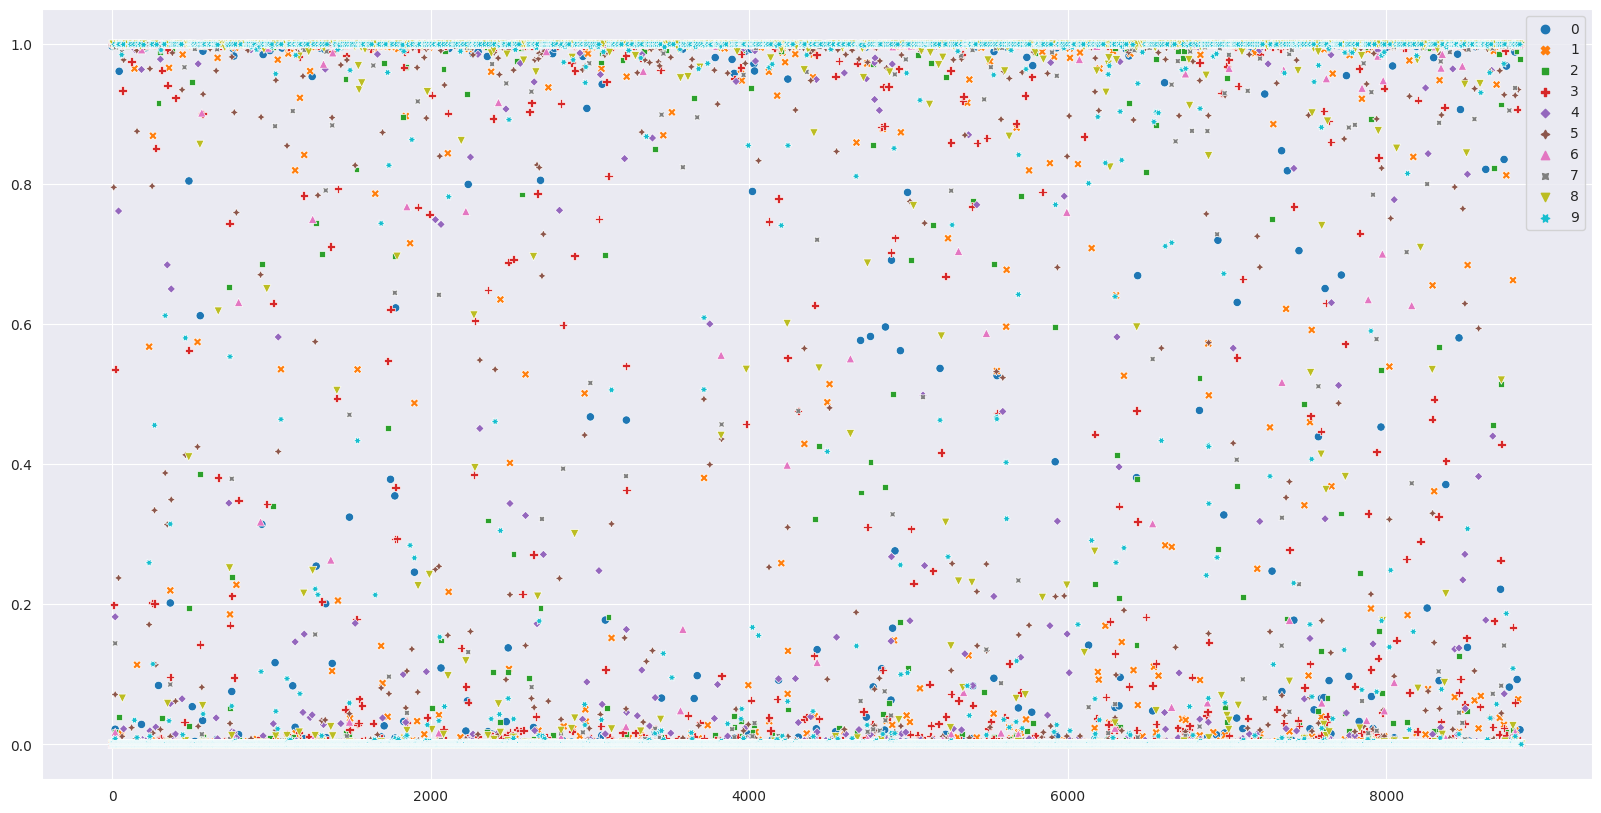

In [27]:
sns.scatterplot(x=y_test,color='red')
sns.scatterplot(y_pred,color='green')

<AxesSubplot: ylabel='Count'>

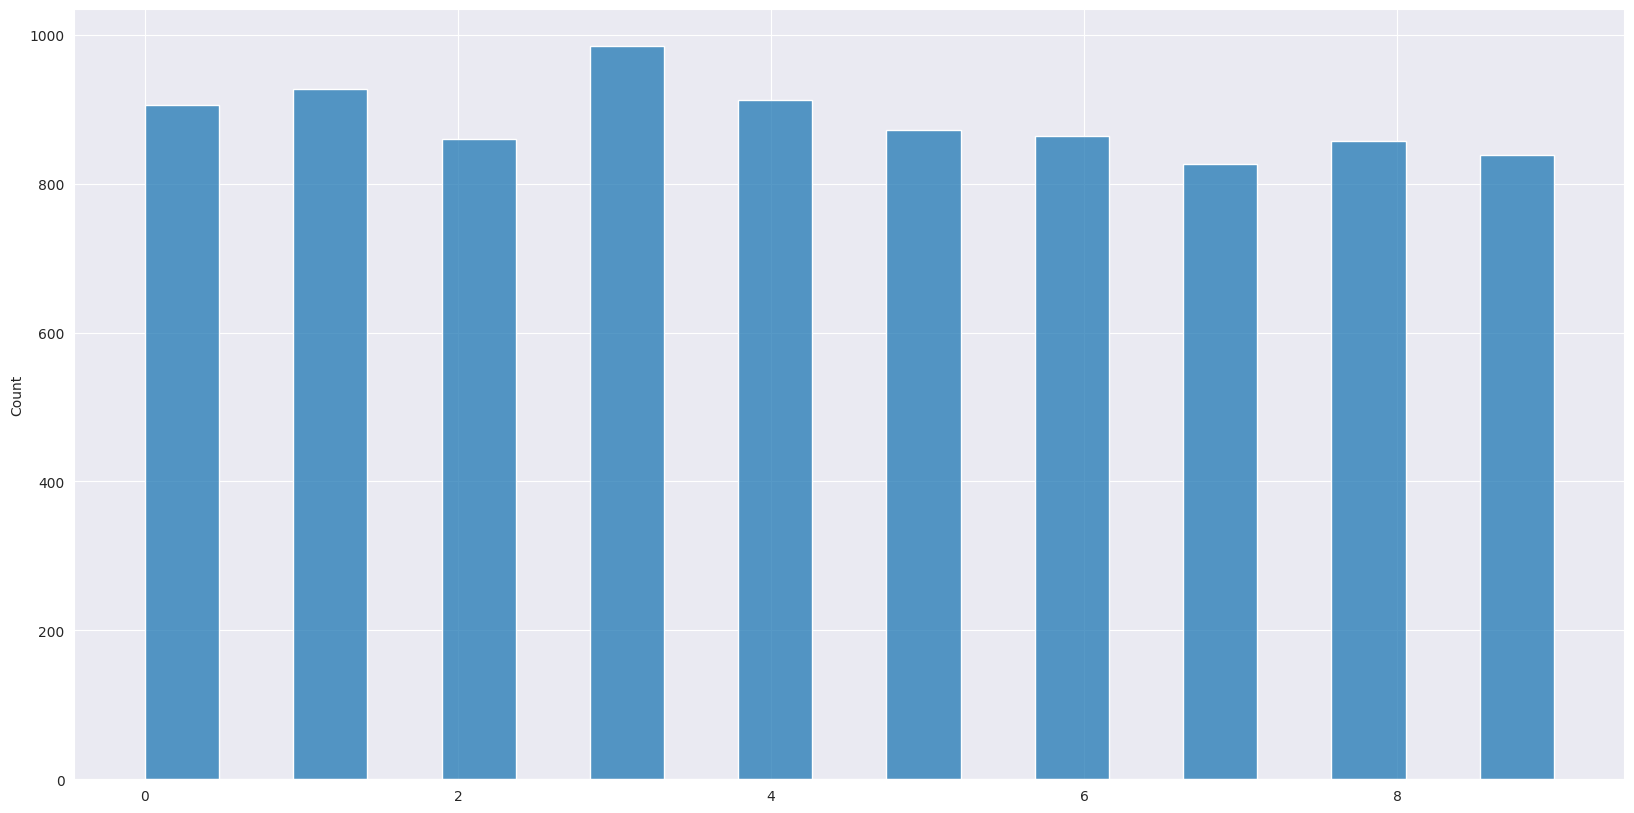

In [32]:
labs= pd.Series(preds)
labs.value_counts()
sns.histplot(labs)